#Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# Transformation for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Download and load the training dataset
trainset_full = datasets.CIFAR100(root='./data', train=True, download=True)

# Split the dataset into train and validation sets
num_train = int(len(trainset_full) * 0.8)  # 80% of data for training
num_val = len(trainset_full) - num_train   # 20% of data for validation
generator1 = torch.Generator().manual_seed(42)
trainset, valset = random_split(trainset_full, [num_train, num_val], generator=generator1)

# Apply the correct transforms to the subsets
trainset = Subset(datasets.CIFAR100(root='./data', train=True, transform=transform_train), trainset.indices)
valset = Subset(datasets.CIFAR100(root='./data', train=True, transform=transform_test), valset.indices)

# DataLoader for the training and validation sets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#Model

In [ ]:
import torch.nn.functional as F

class ModifiedLeNet5(nn.Module):
    def __init__(self):
        super(ModifiedLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout layer after the first fully connected layer
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout layer after the second fully connected layer
        self.fc3 = nn.Linear(192, 100)  # 100 output classes for CIFAR-100

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Second conv + ReLU + MaxPool
        x = x.view(-1, 64 * 8 * 8)           # Flatten
        x = F.relu(self.fc1(x))              # First fully connected layer + ReLU
        x = self.dropout1(x)                 # Apply dropout after the first fully connected layer
        x = F.relu(self.fc2(x))              # Second fully connected layer + ReLU
        x = self.dropout2(x)                 # Apply dropout after the second fully connected layer
        x = self.fc3(x)                      # Output layer
        return x

#Training

In [ ]:
model = ModifiedLeNet5()

num_epochs = 150

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Stochastic Gradient Descent with Momentum)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)


# Define the scheduler (Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):  # Number of epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate after each epoch
    model.eval()  # Set model to evaluate mode
    val_loss = 0.0
    val_steps = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_steps += 1

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss / val_steps}')

    # Step the scheduler
    scheduler.step()

    # Add this after the validation phase in your training loop
    model.eval()  # Ensure model is in evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            # inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct / total
    test_losses.append(average_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Train Loss: 4.391956969070435, Validation Loss: 3.971406172794901
Test Loss: 3.9838, Test Accuracy: 8.42%
Epoch 2, Train Loss: 4.013593758010864, Validation Loss: 3.740890528745712
Test Loss: 3.7445, Test Accuracy: 12.25%
Epoch 3, Train Loss: 3.8301258045196533, Validation Loss: 3.518693062909849
Test Loss: 3.5329, Test Accuracy: 15.75%
Epoch 4, Train Loss: 3.6832197563171385, Validation Loss: 3.3588951864060324
Test Loss: 3.3708, Test Accuracy: 18.82%
Epoch 5, Train Loss: 3.5489189907073975, Validation Loss: 3.1310316347012854
Test Loss: 3.1396, Test Accuracy: 23.15%
Epoch 6, Train Loss: 3.4162073738098147, Validation Loss: 3.113850646717533
Test Loss: 3.1189, Test Accuracy: 23.49%
Epoch 7, Train Loss: 3.313770478057861, Validation Loss: 2.95405827965706
Test Loss: 2.9498, Test Accuracy: 25.47%
Epoch 8, Train Loss: 3.231965041732788, Validation Loss: 2.882828669942868
Test Loss: 2.8832, Test Accuracy: 27.75%
Epoch 9, Train Loss: 3.1563290714263914, Validation Loss: 2.83035582

##Plot Test accuracy

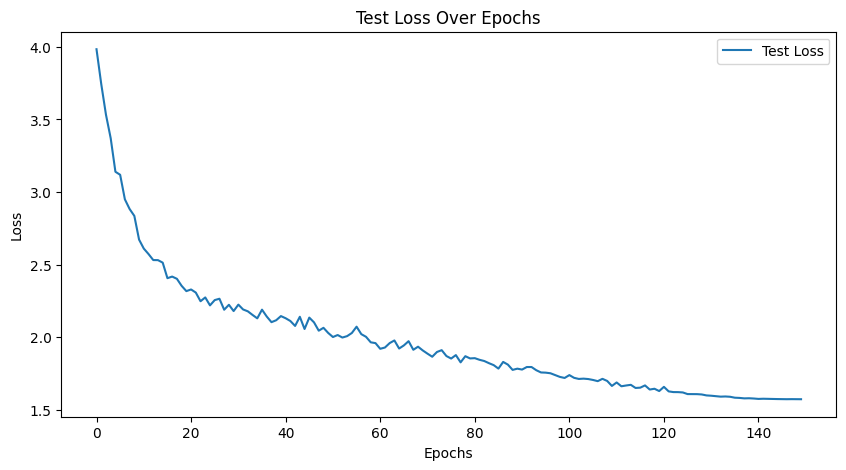

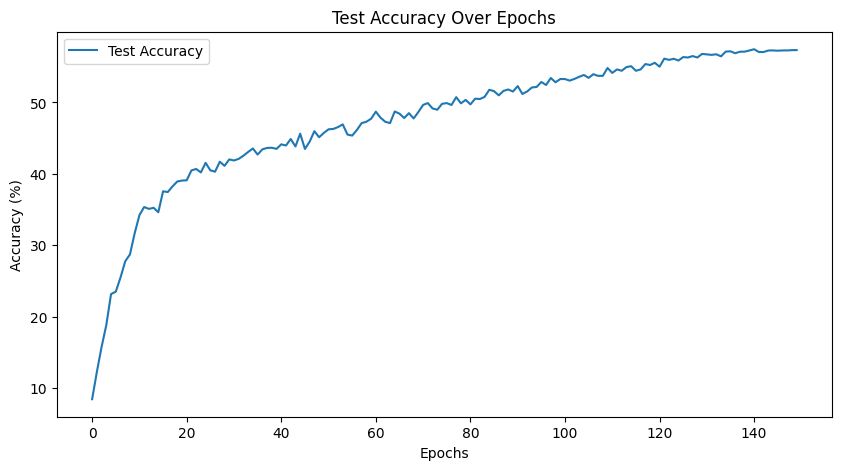

In [ ]:
import matplotlib.pyplot as plt

# Plotting test loss
plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('test_loss_plot.pdf', bbox_inches='tight')  # Save as PDF
plt.show()

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('test_accuracy_plot.pdf', bbox_inches='tight')  # Save as PDF
plt.show()

# Hyparameter Tuning

##lr == 0.1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Supponendo che ModifiedLeNet5, trainset e valset siano definiti altrove

# Hyperparameter grid
learning_rate = 0.1
batch_size = 64
weight_decays = [4e-4, 1e-3, 1e-2]
momentum = 0.9
num_epochs = 150

# Function to train and evaluate the model
def train_and_evaluate(weight_decay):
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ModifiedLeNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_steps += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= val_steps
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Perform grid search
best_hyperparams = None
best_accuracy = 0

for wd in weight_decays:
    print(f'Training with lr={learning_rate}, wd={wd}')
    val_loss, val_accuracy = train_and_evaluate(wd)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparams = (learning_rate, wd)

print(f'Best Hyperparameters: lr={best_hyperparams[0]}, wd={best_hyperparams[1]}')
print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

Training with lr=0.1, wd=0.0004
Validation Loss: 2.1822, Validation Accuracy: 42.65%
Training with lr=0.1, wd=0.001


##lr == 0.01

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Supponendo che ModifiedLeNet5, trainset e valset siano definiti altrove

# Hyperparameter grid
learning_rate = 0.01
batch_size = 64
weight_decays = [4e-4, 1e-3, 1e-2]
momentum = 0.9
num_epochs = 150

# Function to train and evaluate the model
def train_and_evaluate(weight_decay):
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ModifiedLeNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_steps += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= val_steps
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Perform grid search
best_hyperparams = None
best_accuracy = 0

for wd in weight_decays:
    print(f'Training with lr={learning_rate}, wd={wd}')
    val_loss, val_accuracy = train_and_evaluate(wd)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparams = (learning_rate, wd)

print(f'Best Hyperparameters: lr={best_hyperparams[0]}, wd={best_hyperparams[1]}')
print(f'Best Validation Accuracy: {best_accuracy:.2f}%')


Training with lr=0.01, wd=0.0004
Validation Loss: 1.6188, Validation Accuracy: 55.67%
Training with lr=0.01, wd=0.001
Validation Loss: 1.6081, Validation Accuracy: 56.44%
Training with lr=0.01, wd=0.01
Validation Loss: 2.3559, Validation Accuracy: 40.04%
Best Hyperparameters: lr=0.01, wd=0.001
Best Validation Accuracy: 56.44%


##lr == 0.001

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Supponendo che ModifiedLeNet5, trainset e valset siano definiti altrove

# Hyperparameter grid
learning_rate = 0.001
batch_size = 64
weight_decays = [4e-4, 1e-3, 1e-2]
momentum = 0.9
num_epochs = 150

# Function to train and evaluate the model
def train_and_evaluate(weight_decay):
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ModifiedLeNet5()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_steps += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= val_steps
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Perform grid search
best_hyperparams = None
best_accuracy = 0

for wd in weight_decays:
    print(f'Training with lr={learning_rate}, wd={wd}')
    val_loss, val_accuracy = train_and_evaluate(wd)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparams = (learning_rate, wd)

print(f'Best Hyperparameters: lr={best_hyperparams[0]}, wd={best_hyperparams[1]}')
print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

Training with lr=0.001, wd=0.0004
Validation Loss: 2.0622, Validation Accuracy: 45.81%
Training with lr=0.001, wd=0.001
Validation Loss: 2.0833, Validation Accuracy: 44.82%
Training with lr=0.001, wd=0.01


##Scheduler

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, ExponentialLR

# Initialize models, optimizers, criterion, and data loaders


# Define learning rate schedulers
schedulers = {
    "StepLR": StepLR(optimizer, step_size=30, gamma=0.1),
    "ReduceLROnPlateau": ReduceLROnPlateau(optimizer, mode='min', patience=5),
    "CosineAnnealingLR": CosineAnnealingLR(optimizer, T_max=num_epochs),
    "ExponentialLR": ExponentialLR(optimizer, gamma=0.95)
}

# Training loop for each scheduler
for scheduler_name, scheduler in schedulers.items():
    print(f"Training with {scheduler_name} scheduler")
    for epoch in range(num_epochs):
        model.train()
        # Training loop
        for batch_idx, (data, target) in enumerate(trainloader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valloader):
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(valloader)}, Validation Accuracy: {100.*correct/total}")
        scheduler.step(val_loss)  # For ReduceLROnPlateau scheduler

Training with StepLR scheduler
Epoch 1/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 3/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 4/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 5/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 6/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 7/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 8/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 9/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 10/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 11/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 12/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 13/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 14/150, Validation Loss: 4.031605377318753, Validation Accuracy: 7.56
Epoch 15/150, Valida